<a href="https://colab.research.google.com/github/JHyunjun/SNU/blob/main/AE%20for%20AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Autoencoders

This material is based on [Intro to Autoencoders](https://www.tensorflow.org/tutorials/generative/autoencoder) and may be copyrighted by the original writers. For educational uses only.

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. 

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

## Import TensorFlow and other libraries

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Anomaly detection

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [28]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()
print(dataframe.shape)

(4998, 141)


In [29]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [30]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [31]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG. 

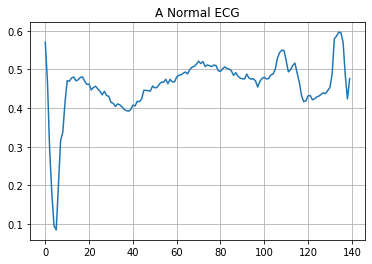

In [32]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

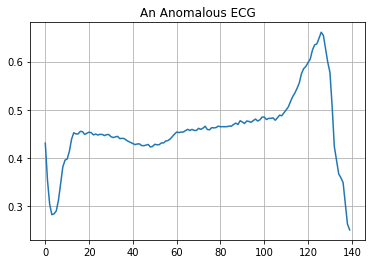

In [33]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [34]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector,self).__init__()
    self.layer1 = tf.keras.layers.Dense(140, activation = 'relu')
    self.layer2 = tf.keras.layers.Dense(30, activation = 'relu')
    self.layer3 = tf.keras.layers.Dense(140,activation = 'sigmoid')

  def call(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    return x
  
autoencoder = AnomalyDetector()

In [35]:
# define optimizer and compile
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [36]:
# Train
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(normal_test_data, normal_test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 0s 33ms/step - loss: 0.0076 - val_loss: 0.0067
Epoch 2/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 4/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 5/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 6/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 7/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 8/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 9/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 10/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 11/20
5/5 [===================

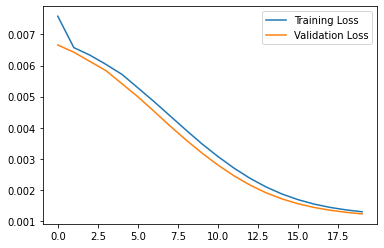

In [37]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

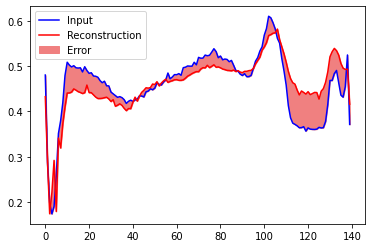

In [38]:
# Reconstruct normal test data 
x = autoencoder.layer1(normal_test_data)
x = autoencoder.layer2(x)
x = autoencoder.layer3(x)
decoded_imgs = x


plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

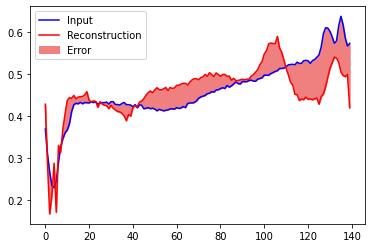

In [39]:
# Reconstruct anomalous test data 
x = autoencoder.layer1(anomalous_test_data)
x = autoencoder.layer2(x)
x = autoencoder.layer3(x)
decoded_imgs = x

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

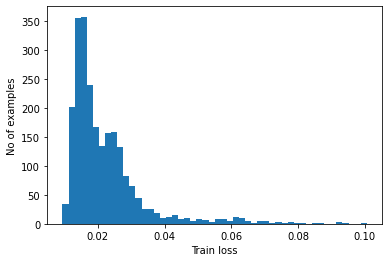

In [40]:
# Calculate recontruction loss on normal train data 
################ Implementation ################
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
################ Implementation ################

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [41]:
# Calculate a threshold (mean + std)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.033299506


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial. 

If you examine the recontruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier. 

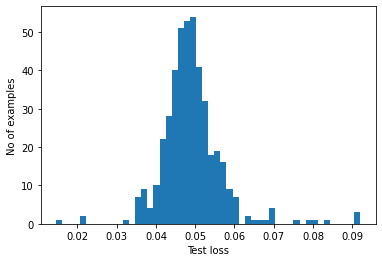

In [42]:
# Calculate recontruction loss on anomalous test data 
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [43]:
def predict(model, data, threshold):
  # Classify data as an anomaly if reconstrucion loss > threshold
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)
  
preds = predict(autoencoder, test_data, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [44]:
# Call 'predict' function
print_stats(preds, test_labels)

Accuracy = 0.946
Precision = 0.9922178988326849
Recall = 0.9107142857142857
